# Data Cleaning Notebook

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import regex as re

## Data

In [3]:
df = pd.read_csv('jobs_dataset.csv')
df.head()

Unnamed: 0                                          Position   Job Type  \
0           0  Data Architect - SaaS/Workday/Finance - Coventry   Contract   
1           1                                    Data Architect  Permanent   
2           2                                      Data Analyst   Contract   
3           3                                      Data Analyst   Contract   
4           4                          Data Solutions Architect  Permanent   

                                       Rate  \
0                       £650 - £700 per Day   
1                      Up to £80k per annum   
2                       £325 - £350 per Day   
3          £300 - 350 per Day + Inside IR35   
4  £70k - 80k per year + Extensive benefits   

                                 Location                         Recruiter  \
0              Coventry, Warwickshire, UK                   Crimson Limited   
1             Solihull, West Midlands, UK                       Harvey Nash   
2                          Birmingham, UK                       Harvey Nash   
3  Birmingham, West Midlands, England, UK  Adalta Recruitment Solutions Ltd   
4  Birmingham, West Midlands, England, UK                   Cloud Decisions   

         Reference                                        Description  
0  JS-CR/CR/014020  Data Architect - SaaS/Workday/Finance - Covent...  
1     JS-BBBH78205  Data ArchitectPermanentc/£80,000 p/a + bonus +...  
2     JS-BBBH78228  Data analystLocation: BirminghamEmployment typ...  
3           JS7425   Data Analyst - HR, Insights, Diversity  Locat...  
4   JSKF/LM/810144  Data Solutions ArchitectRemote role (UK based)...

## 1. Remove Duplicates

Check and remove any duplicate postings

In [4]:
df.shape[0]

501

In [5]:
df.drop_duplicates('Description', keep= 'first')
df.shape[0]

501

No duplicates

## 2. Job title

There are many different positions in the Data field. The Position column does not show any uniform standard and so some include extra information that's not needed for job title.  

### Observing Common Jobs
First, to see the most common positions, I will create a word cloud to quickly identify the prominent job titles.


Credit: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

In [6]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

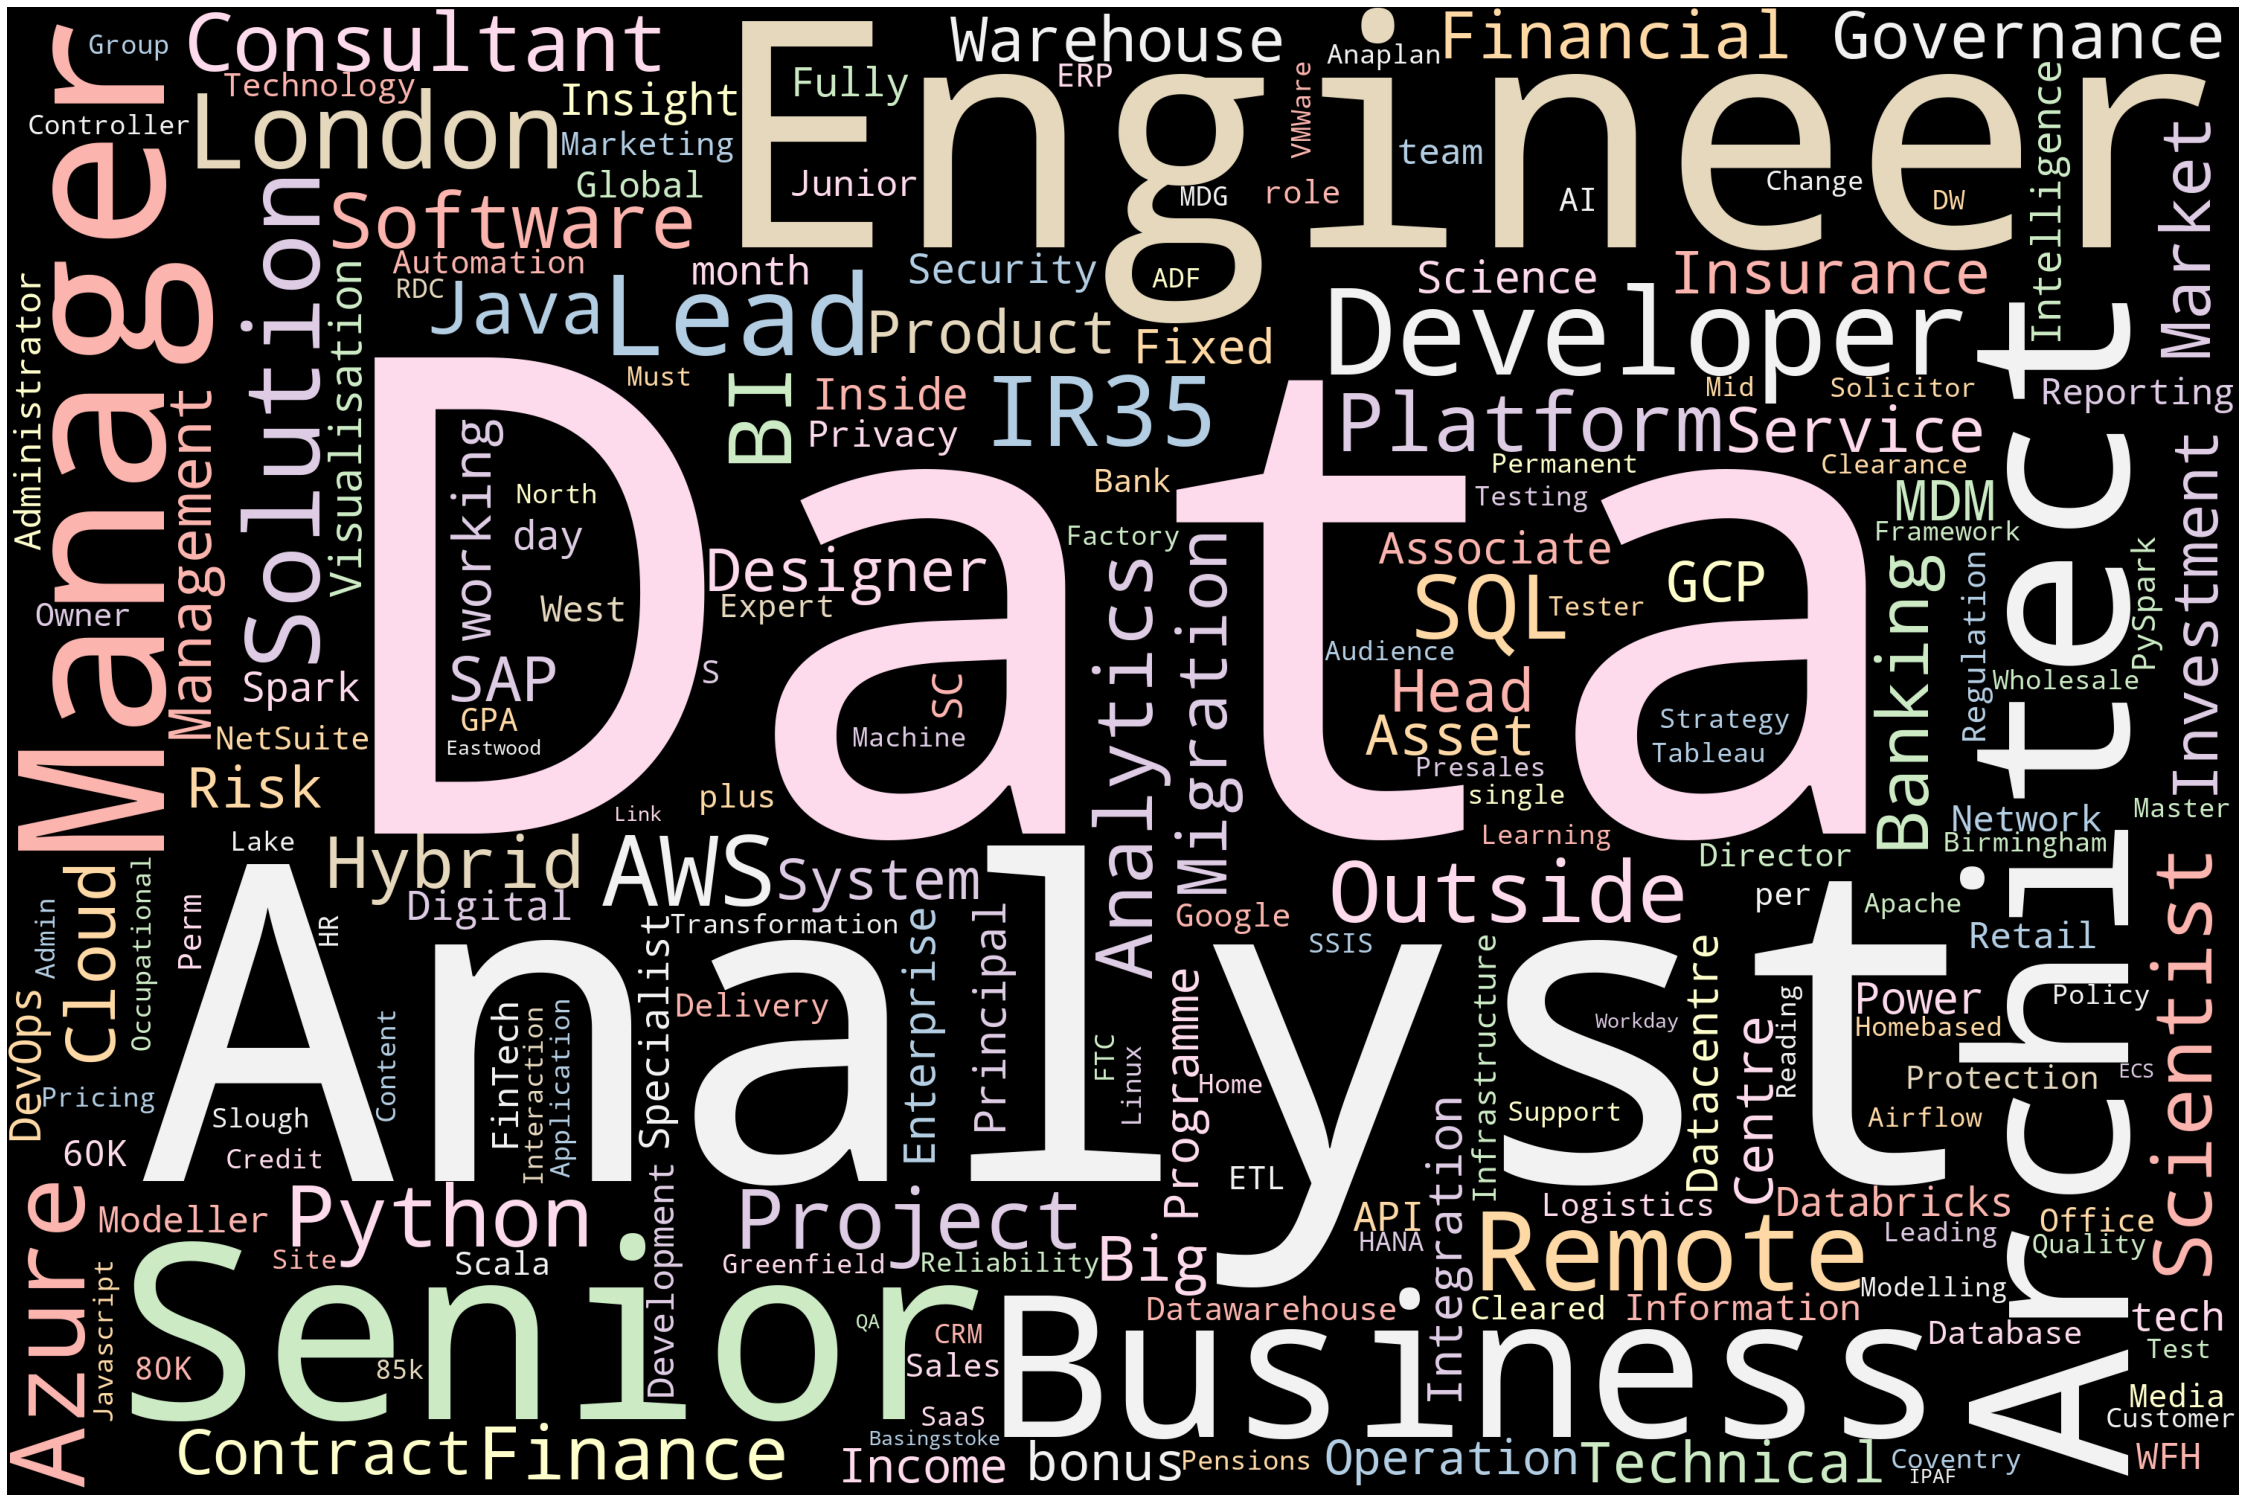

In [7]:
# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(df['Position']))
# Plot
plot_cloud(wordcloud)

Since the word "data" isn't really useful in this context, i'll remove it so we can better see what's left.

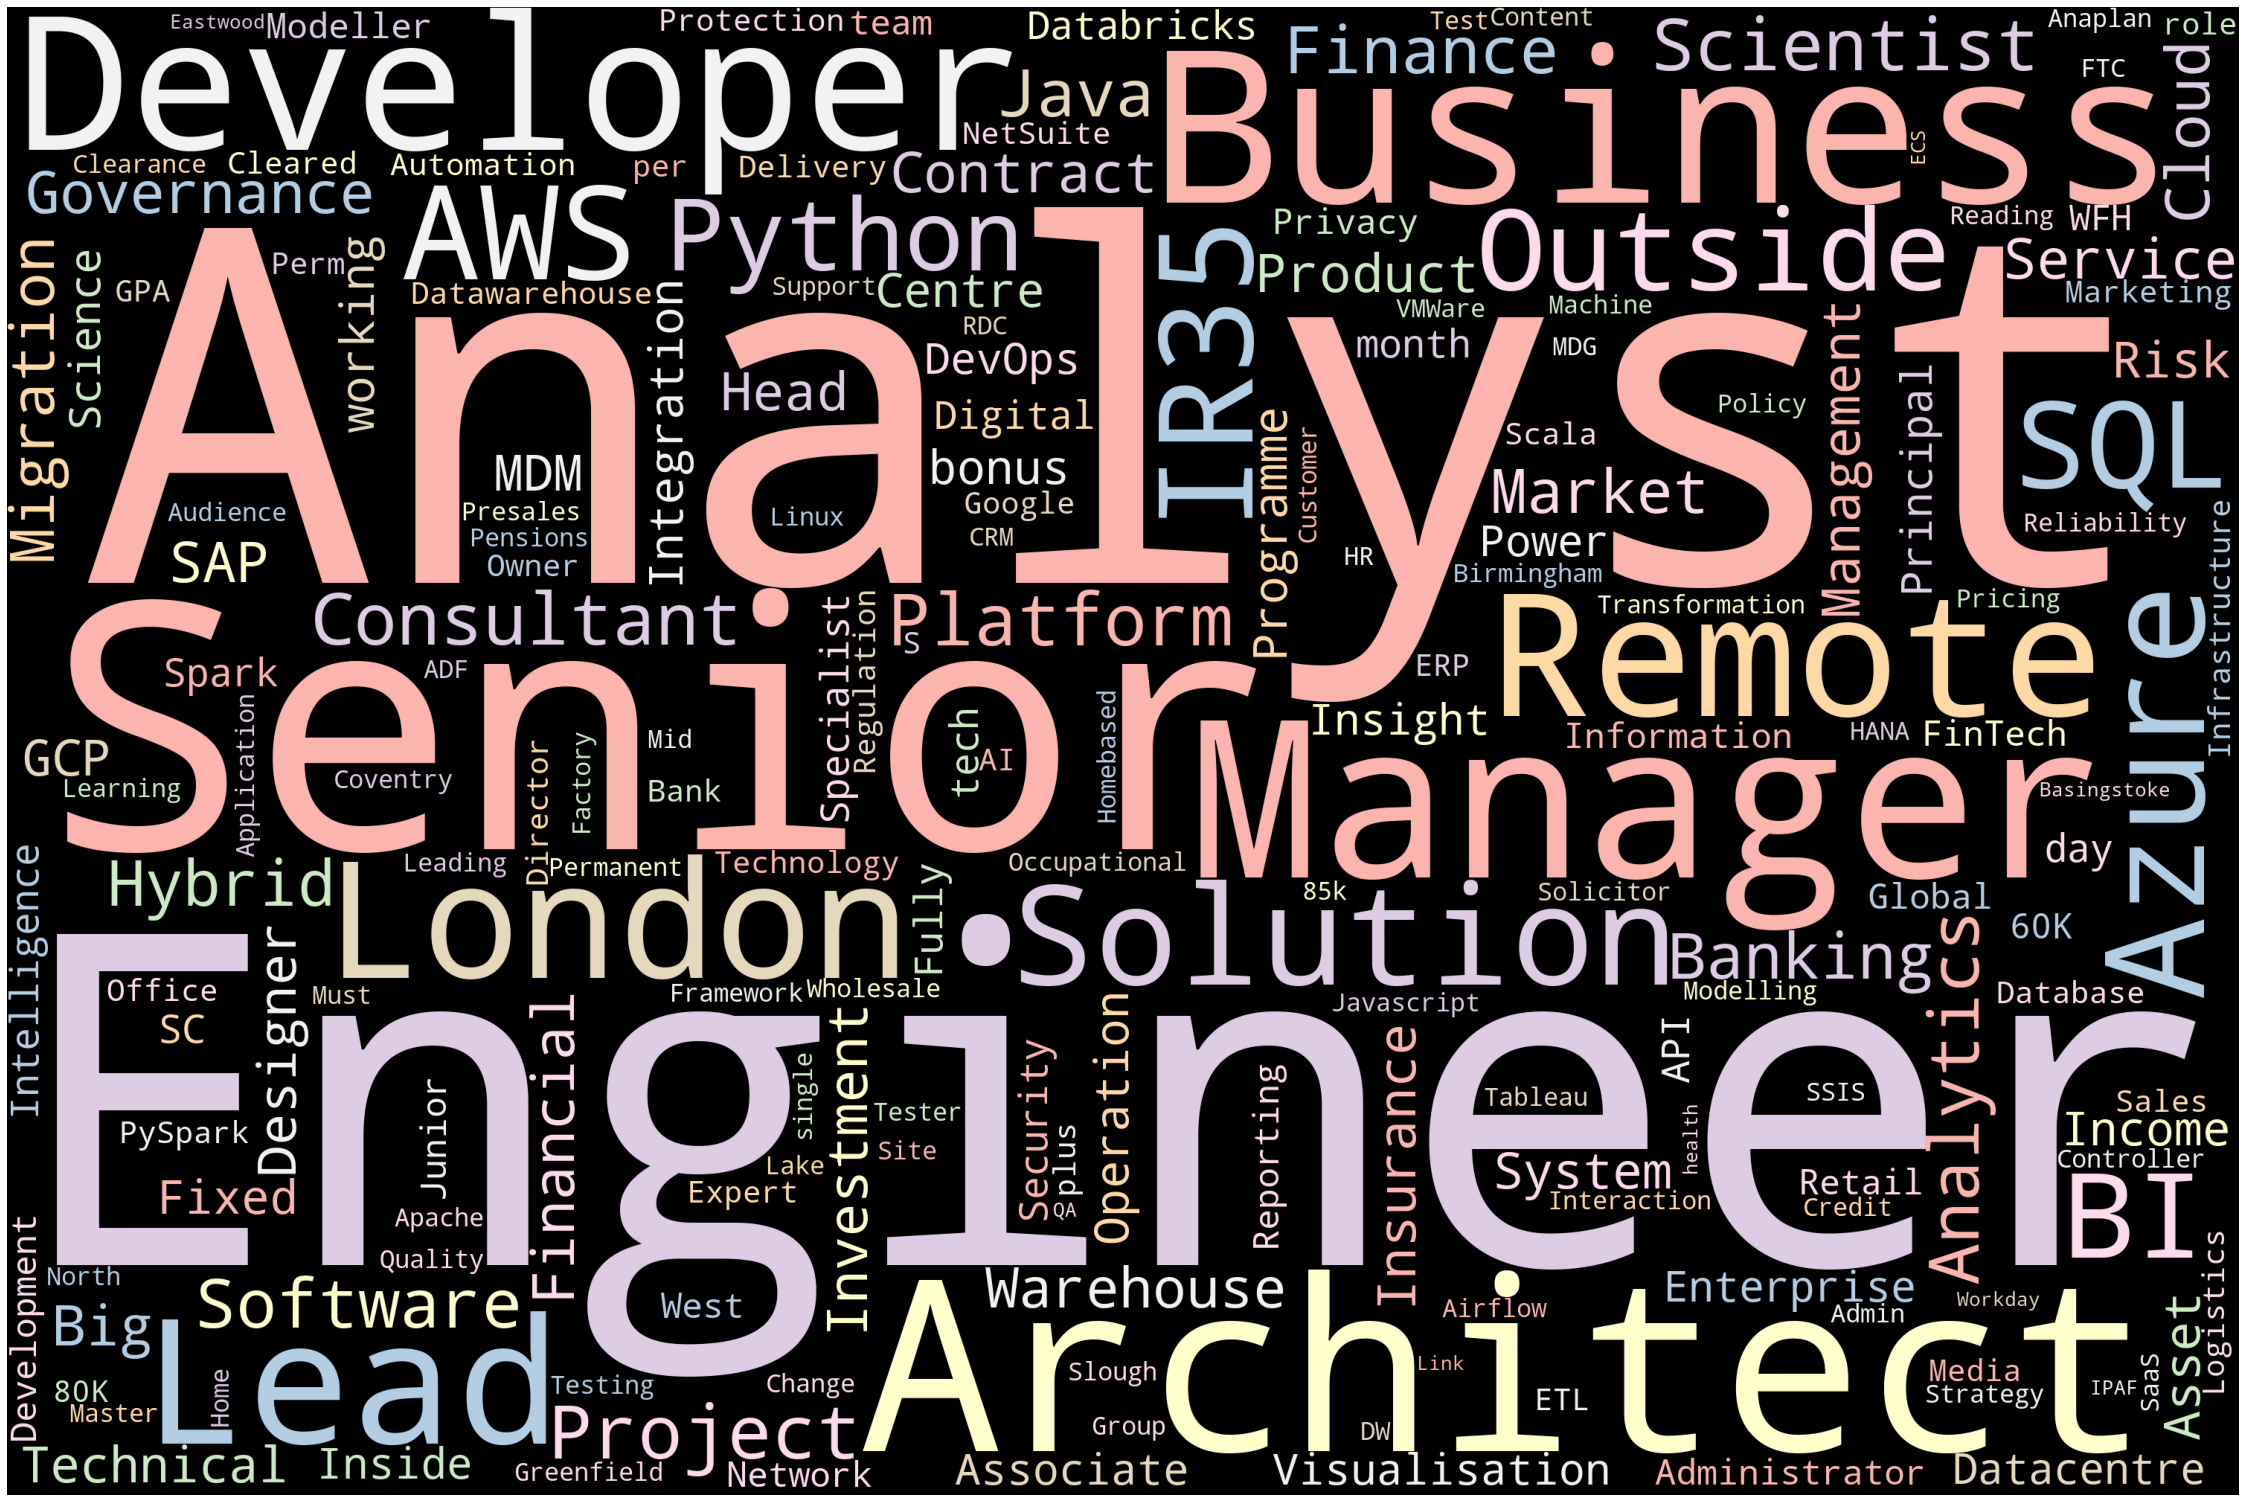

In [8]:
stopwords = ['data']+list(STOPWORDS)

wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, colormap='Pastel1', collocations=False, stopwords = stopwords).generate(' '.join(df['Position']))

plot_cloud(wordcloud)

From this we can see some roles stand out.

Data:
- Analyst
- Engineer
- Architect
- Scientist

Using these broad categories, we will next group the Positions into one of these job titles. Any ones that do not fit will be categorised as 'other'


### Grouping Job Types

In [9]:
def job_grouper(data):
    data.loc[data['Position'].str.contains('analyst', case= False), 'Position'] = 'Data Analyst'
    data.loc[data['Position'].str.contains('engineer', case= False), 'Position'] = 'Data Engineer'
    data.loc[data['Position'].str.contains('architect', case= False), 'Position'] = 'Data Architect'
    data.loc[data['Position'].str.contains('scientist', case= False), 'Position'] = 'Data Scientist'

    return data

In [10]:
df_2 = df.copy()

df_2 = job_grouper(df_2)
df_2.loc[~df_2['Position'].str.contains('analyst|engineer|architect|scientist', case= False), 'Position'] = 'Other'

<AxesSubplot:>

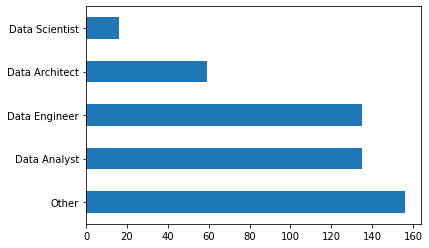

In [11]:
df_2['Position'].value_counts().plot.barh()

There are alot of 'other', so let's take a look at any common themes here

In [12]:
df_2b = df.copy()
df_2b = job_grouper(df_2b)
df_2b = df_2b[df_2b['Position'].str.contains('analyst|engineer|architect|scientist', case= False) == False]


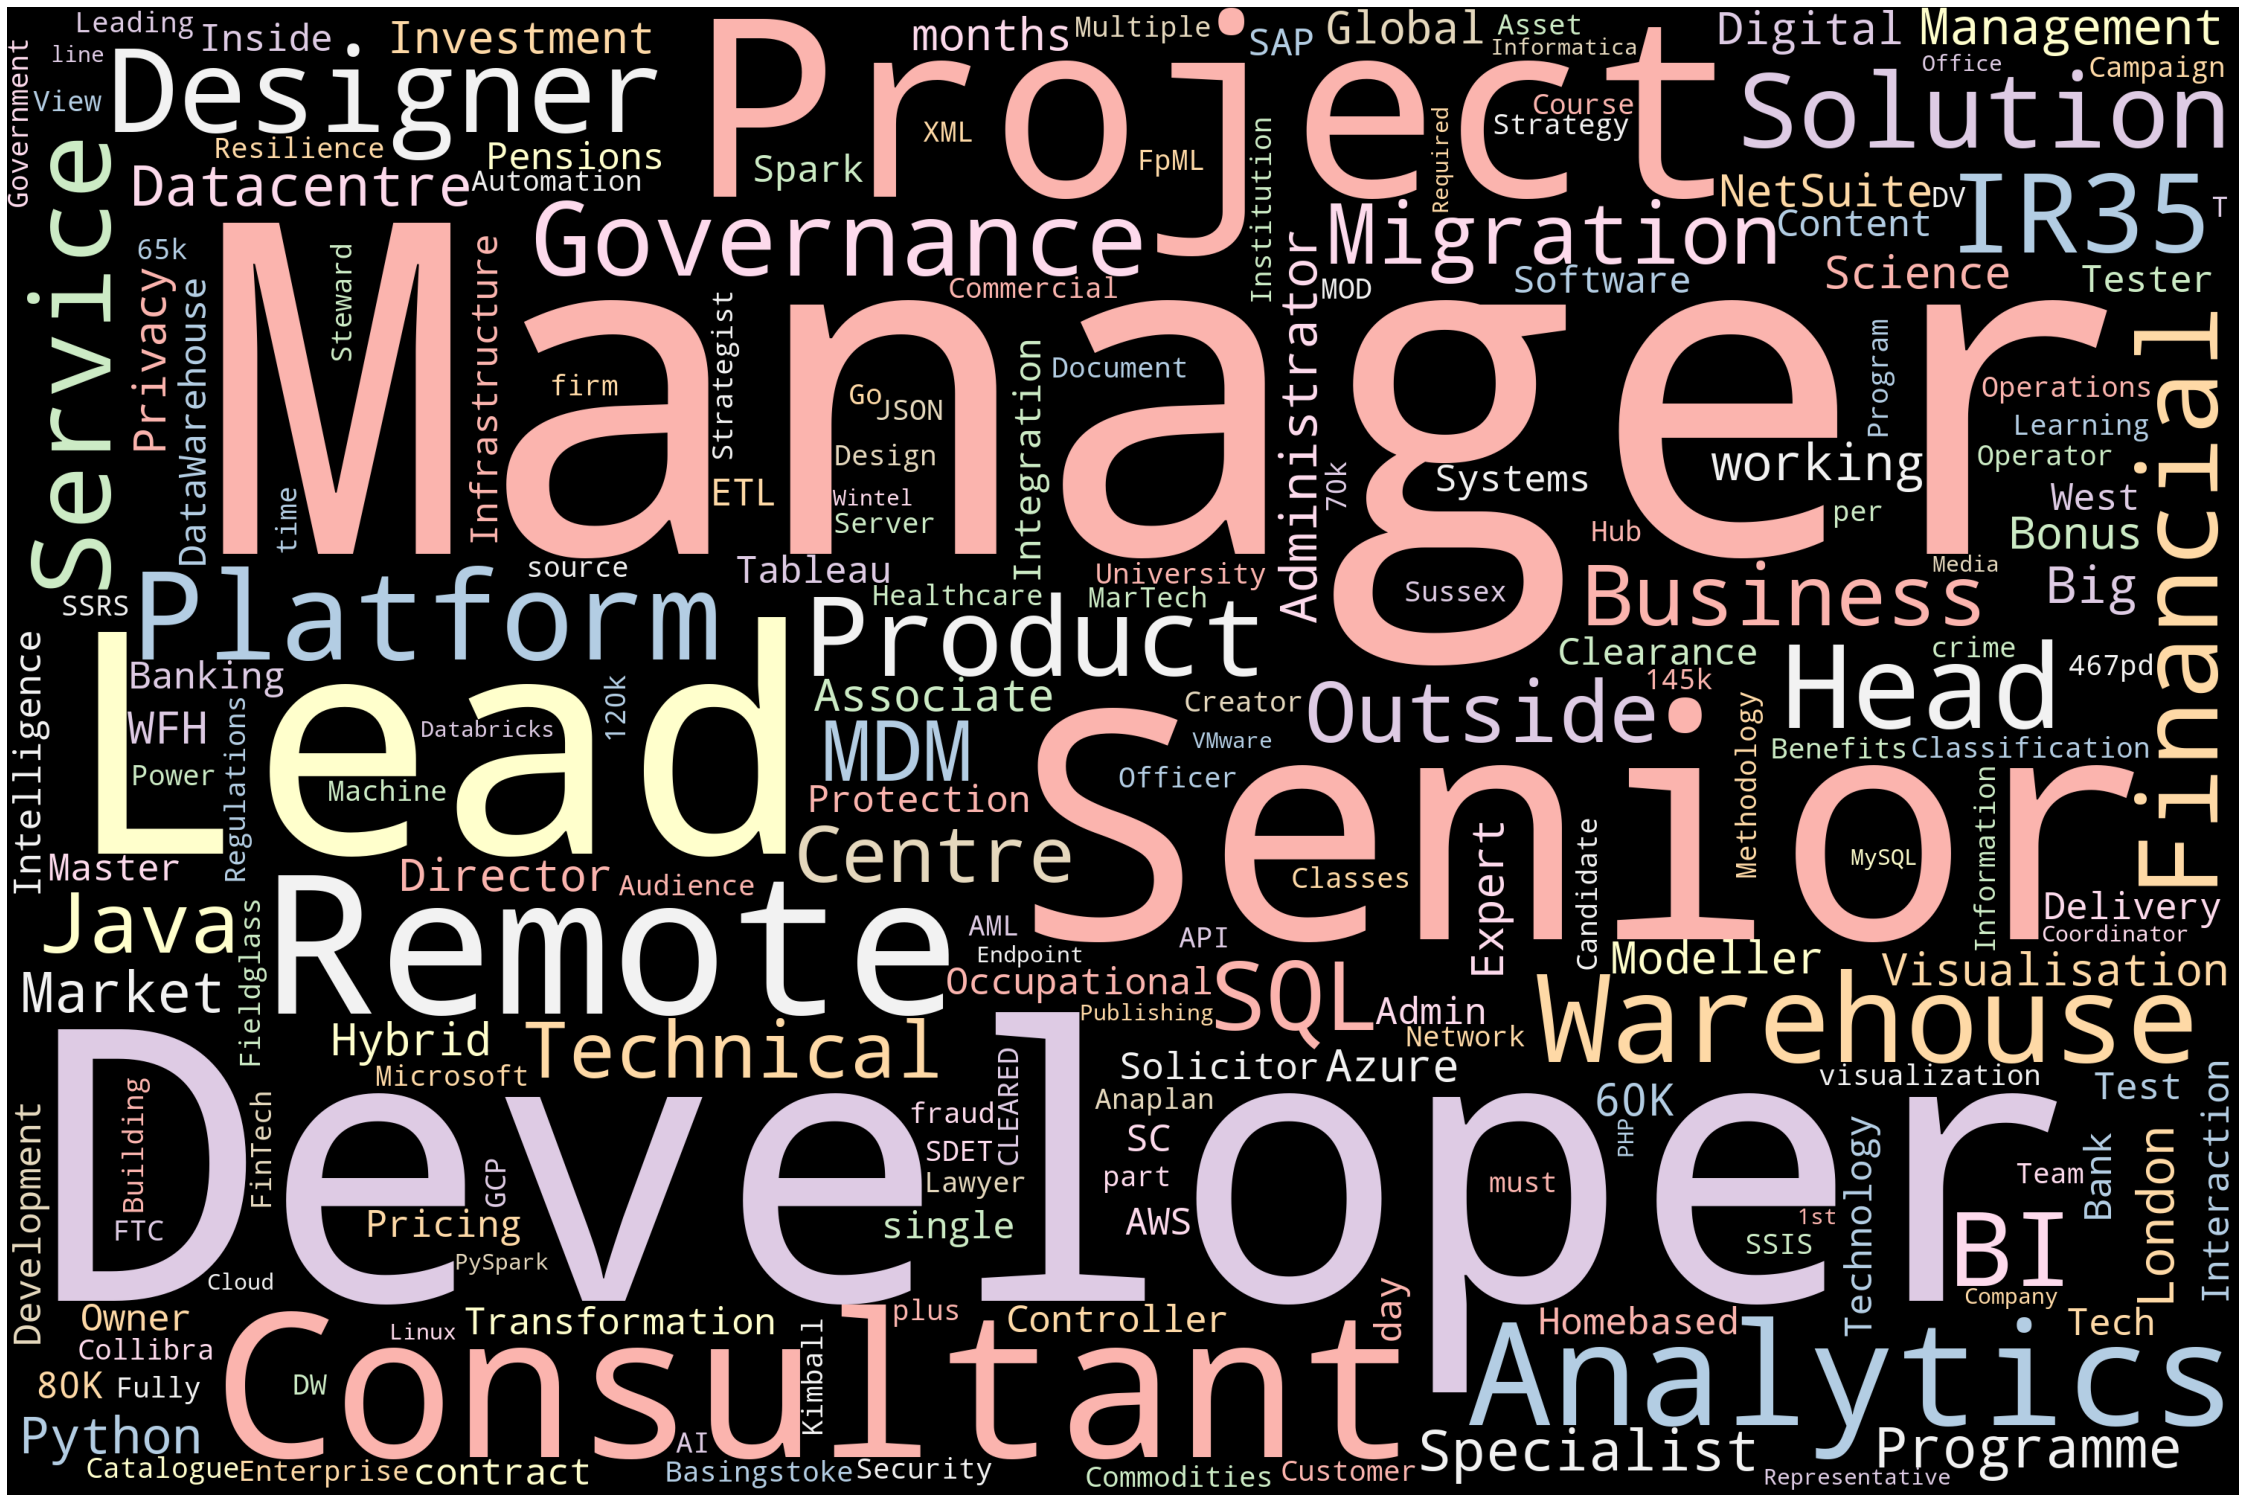

In [13]:
# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, colormap='Pastel1', collocations=False, stopwords = stopwords).generate(' '.join(df_2b['Position']))
# Plot
plot_cloud(wordcloud)

These seem to be more managerial or speialist roles, so we will leave this out of out current analysis. Perhaps something to return to in future.

<AxesSubplot:>

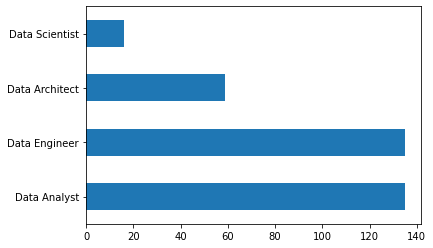

In [14]:
df_3 = df_2[df_2['Position'].str.contains('other', case= False) == False]
df_3['Position'].value_counts().plot.barh()


## 3. Salary / Rate

Looking at the data, the way the salaries are recorded depends on the contract type. If a permanent position it would be per annum, and if a contract then per day. However, there is also a few that are measured per hour but since these are less relevent, I took them out.

Initially I thought to make 3 columns that standardise the rate per annum, per day and per hour equivalent regardless of contract type, however since both types differ a lot in terms of contract length, working days etc, I chose not to do this. Instead I will keep both job types seperate.

 I will do this using Regex and lambda functions since I need to practice those.

In [15]:
df_sal = df_3.copy()

In [16]:
df_sal = df_sal[df_sal['Rate'].str.contains('hour') == False]

In [17]:
df_sal['Rate'] = df_sal['Rate'].str.replace('£','')
df_sal['Rate'] = df_sal['Rate'].str.replace('+','')
df_sal['Rate'] = df_sal['Rate'].str.replace('%','')
df_sal['Rate'] = df_sal['Rate'].str.replace('k','000', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('up to','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('outside','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('inside','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('IR35','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace(' - ','-')
df_sal['Rate'] = df_sal['Rate'].str.replace(',','')
df_sal['Rate'] = df_sal['Rate'].str.replace('Circa','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('to','', case=False)
df_sal['Rate'] = df_sal['Rate'].str.replace('c','', case=False)


C:\Users\aksc7\AppData\Local\Temp/ipykernel_17140/751394920.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sal['Rate'] = df_sal['Rate'].str.replace('+','')


In [18]:
df_sal['Rate'] = df_sal['Rate'].str.replace(r'p(.*)', '', regex=True, case=False)
df_sal['Rate'] = df_sal['Rate'].str.lstrip()
df_sal['Rate'] = df_sal['Rate'].str.replace(r' (.*)', '', regex=True)
df_sal['Rate'] = df_sal['Rate'].str.replace(r'/d(.*)', '', regex=True, case=False)


In [19]:
# If it is a range, here it will be averaged
def split_rate(i):
    try:
        splt = i.split('-',1)
        first = float(splt[0])
        second = float(splt[1])
        return (first + second)/2
    except:
        return float(i)

In [20]:
df_sal['Rate'] = df_sal['Rate'].apply(split_rate)

## Location

Since all these job postings are from UK, I will drop this information from this column.

I will also remove any mention of Wales, England or Scotland etc. 

if contains (from list) then replace with relevent city (from list)

join geoJSON or long lat data for mapping later.

In [23]:
df_loc = df_sal.copy()

In [25]:
df_loc['Location'] = df_loc['Location'].str.replace('UK','', case= False)
df_loc['Location'] = df_loc['Location'].str.replace('England | Scotland | Wales','', case= False)

C:\Users\aksc7\AppData\Local\Temp/ipykernel_17140/564302737.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_loc['Location'] = df_loc['Location'].str.replace('England | Scotland | Wales','', case= False)


In [27]:
df_loc['Location'] = df_loc['Location'].str.replace(r',(.*)', '', regex=True, case=False)


In [47]:
df_loc.loc[df_loc['Location'].str.contains('wfh', case= False), 'Location'] = 'Remote'
df_loc.loc[df_loc['Location'].str.contains('remote', case= False), 'Location'] = 'Remote'
df_loc.loc[df_loc['Location'].str.contains('united kingdom', case= False), 'Location'] = 'Remote'
df_loc.loc[df_loc['Location'].str.contains('home', case= False), 'Location'] = 'Remote'
df_loc.loc[df_loc['Location'].str.contains('hybrid', case= False), 'Location'] = 'Hybrid'
df_loc.loc[df_loc['Location'].str.contains('south', case= False), 'Location'] = 'Hybrid'
df_loc.loc[df_loc['Location'].str.contains('midlands', case= False), 'Location'] = 'Hybrid'
df_loc.loc[df_loc['Location'].str.contains('london', case= False), 'Location'] = 'London'
df_loc.loc[df_loc['Location'].str.contains('manchester', case= False), 'Location'] = 'Manchester'

In [48]:
df_loc

Unnamed: 0        Position   Job Type      Rate    Location  \
0             0  Data Architect   Contract     675.0    Coventry   
1             1  Data Architect  Permanent   80000.0    Solihull   
2             2    Data Analyst   Contract     337.5  Birmingham   
3             3    Data Analyst   Contract     325.0  Birmingham   
4             4  Data Architect  Permanent   75000.0  Birmingham   
..          ...             ...        ...       ...         ...   
489         489   Data Engineer  Permanent  105000.0      London   
492         492   Data Engineer   Contract     700.0      London   
493         493  Data Architect   Contract     720.0      London   
494         494  Data Architect   Contract     537.5      London   
495         495   Data Engineer  Permanent   85000.0      London   

                            Recruiter        Reference  \
0                     Crimson Limited  JS-CR/CR/014020   
1                         Harvey Nash     JS-BBBH78205   
2                         Harvey Nash     JS-BBBH78228   
3    Adalta Recruitment Solutions Ltd           JS7425   
4                     Cloud Decisions   JSKF/LM/810144   
..                                ...              ...   
489                  Joseph Harry Ltd           JS-PHE   
492                  Joseph Harry Ltd           JS-PHE   
493               Jumar Solutions Ltd     JSBH-14228-1   
494     Jefferson Frank International       JS-SOLARCH   
495          Rainmaker People Limited    JSCNRUBYSNR04   

                                           Description  
0    Data Architect - SaaS/Workday/Finance - Covent...  
1    Data ArchitectPermanentc/£80,000 p/a + bonus +...  
2    Data analystLocation: BirminghamEmployment typ...  
3     Data Analyst - HR, Insights, Diversity  Locat...  
4    Data Solutions ArchitectRemote role (UK based)...  
..                                                 ...  
489  Lead Java Developer (Java Developer Programmer...  
492  Lead Java Developer (Java Developer Programmer...  
493  Solution Architect x2£720 inside ir356 months ...  
494  Solutions Architect | Outside IR35 | Contract ...  
495  Ruby on Rails - Senior Back End Engineer Our c...  

[340 rows x 8 columns]

## Description

Extracting Key Skills, Tools and Languages

In [51]:
df_desc = df_loc.copy()

Will create new columns per skill, tool, language I am interested in. If the description contains these terms, the column will flag it.

In [99]:
df_desc['Python'] = df['Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df_desc['Power BI'] = df['Description'].apply(lambda x: 1 if 'powerbi' in x.lower() or 'power bi' in x.lower() else 0)
df_desc['Tableau'] = df['Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)
df_desc['SQL'] = df['Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df_desc['R'] = df['Description'].apply(lambda x: 1 if 'R.' in x or ' R ' in x or "'R'" in x else 0)
df_desc['Azure'] = df['Description'].apply(lambda x: 1 if 'azure' in x.lower() else 0)
df_desc['AWS'] = df['Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df_desc['Google Analytics'] = df['Description'].apply(lambda x: 1 if 'google analytics' in x.lower() else 0)
df_desc['Machine Learning'] = df['Description'].apply(lambda x: 1 if 'machine learning' in x.lower() else 0)

## Final Dataset

In [100]:
df_out = df_desc.copy() 
df_out.columns

Index(['Unnamed: 0', 'Position', 'Job Type', 'Rate', 'Location', 'Recruiter',
       'Reference', 'Description', 'Python', 'Power BI', 'SQL', 'R', 'Azure',
       'Tableau', 'AWS', 'Google Analytics', 'Machine Learning'],
      dtype='object')

In [101]:
df_out = df_out.drop(['Unnamed: 0'], axis=1)
df_out.columns

Index(['Position', 'Job Type', 'Rate', 'Location', 'Recruiter', 'Reference',
       'Description', 'Python', 'Power BI', 'SQL', 'R', 'Azure', 'Tableau',
       'AWS', 'Google Analytics', 'Machine Learning'],
      dtype='object')

In [102]:
df_out.to_csv('jobs_dataset_cleaned.csv', index= False)